## $Z^*$ known

### Training Steps

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc, corr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def pairwise_corr(z, z_):
    return np.mean([corr(a, b)[0] for a, b in zip(z.T, z_.T)])

def cossim(z, z_):
    return -F.cosine_similarity(z.T, z_.T).mean()

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    criterion = cossim
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_ = model(X_train)
        loss = criterion(S_train, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(pairwise_corr(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_ = model(X_test)
                loss = criterion(S_test, S_)
            log['loss_test'].append(loss.item())
            log['mcc_test'].append(pairwise_corr(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy()))
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0)
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256, 1024]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i
    
    SAE = nn.Sequential(nn.Linear(M, N), nn.ReLU()).to(device)
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        MLP = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU()).to(device)
        logs_mlps[h].append(run_experiment(MLP, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "MLPs": avg_mlps
}

# New function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_training_steps.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

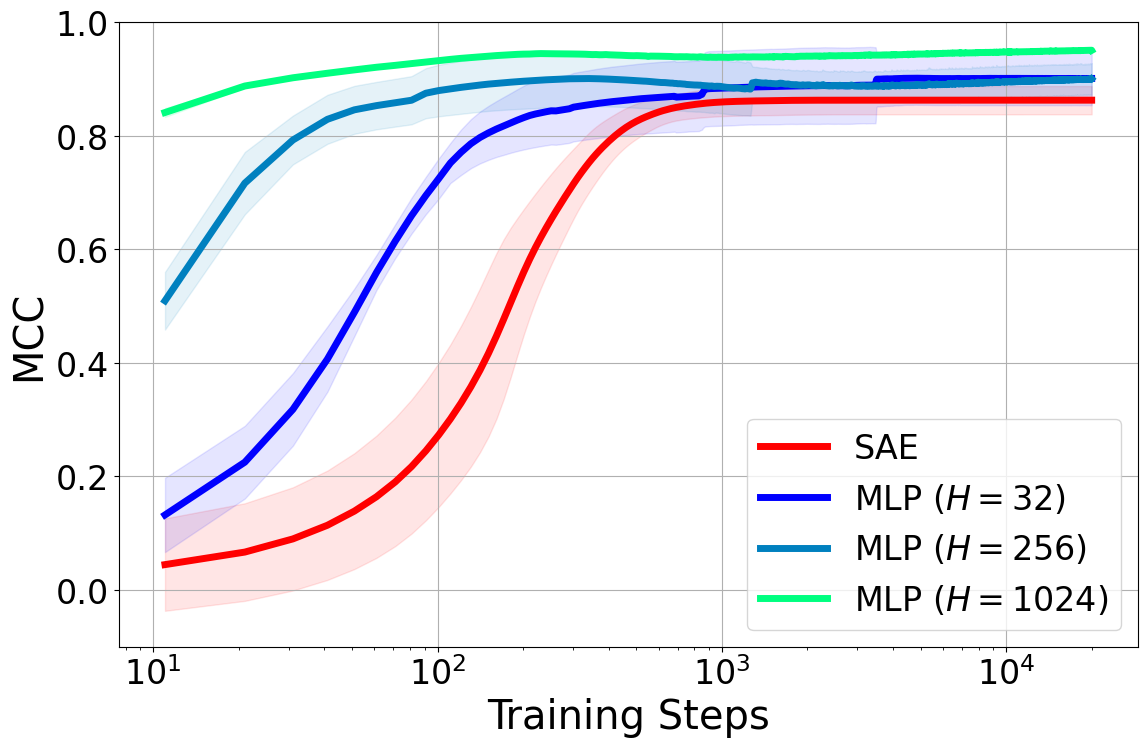

In [17]:
# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-', 
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1, 
                 avg_sae['mcc_test'] - avg_sae['mcc_test_std'], 
                 avg_sae['mcc_test'] + avg_sae['mcc_test_std'], 
                 alpha=alpha, color='red')

colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-', 
             color=color, label=f'MLP ($H={h}$)', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1, 
                     avg_mlp['mcc_test'] - avg_mlp['mcc_test_std'], 
                     avg_mlp['mcc_test'] + avg_mlp['mcc_test_std'], 
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_D_training_steps.pdf', dpi=300, bbox_inches='tight')
plt.show()

### FLOPs

In [14]:
def calculate_sae_inference_flops(M, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # Linear layer FLOPs
    linear_flops = (2 * M * N)  # includes matrix multiplication and bias addition
    
    # ReLU activation FLOPs
    relu_flops = N  # one comparison per output neuron
    
    # Total FLOPs for one sample
    flops_per_sample = linear_flops + relu_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_sae_training_flops(M, N, num_samples, num_steps, batch_size=None):
    """
    Calculate the number of FLOPs for training an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_sae_inference_flops(M, N, 1)
    
    # Backward pass FLOPs
    relu_grad_flops = N  # ReLU gradient
    linear_grad_flops = (2 * N * M) + N  # Linear layer gradient
    weight_update_flops = 2 * (M * N + N)  # Weight update
    
    backward_flops = relu_grad_flops + linear_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

# Example usage:
M, N = 8, 16
num_samples = 1024
num_steps = 20000

inference_flops = calculate_sae_inference_flops(M, N, num_samples)
training_flops = calculate_sae_training_flops(M, N, num_samples, num_steps)

print(f"Inference FLOPs: {inference_flops}")
print(f"Training FLOPs: {training_flops}")

Inference FLOPs: 278528
Training FLOPs: 17367040000


In [15]:
def calculate_mlp_inference_flops(M, h, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # First Linear layer FLOPs
    linear1_flops = 2 * M * h
    
    # First ReLU activation FLOPs
    relu1_flops = h
    
    # Second Linear layer FLOPs
    linear2_flops = 2 * h * N
    
    # Second ReLU activation FLOPs
    relu2_flops = N
    
    # Total FLOPs for one sample
    flops_per_sample = linear1_flops + relu1_flops + linear2_flops + relu2_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_mlp_training_flops(M, h, N, num_samples, num_steps, batch_size=None):
    """
    Calculate the number of FLOPs for training an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_mlp_inference_flops(M, h, N, 1)
    
    # Backward pass FLOPs
    relu2_grad_flops = N
    linear2_grad_flops = (2 * N * h) + N
    relu1_grad_flops = h
    linear1_grad_flops = (2 * M * h) + h
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * h + h + h * N + N)
    
    # Total backward pass FLOPs
    backward_flops = relu2_grad_flops + linear2_grad_flops + relu1_grad_flops + linear1_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_training_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    # Total FLOPs for testing (inference on test set)
    total_testing_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    
    # Grand total FLOPs
    grand_total_flops = total_training_flops + total_testing_flops
    
    return grand_total_flops

# Example usage:
M, N = 8, 16
hidden_layers = [32, 256, 1024]
num_samples = 1024
num_steps = 20000

for h in hidden_layers:
    inference_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    training_flops = calculate_mlp_training_flops(M, h, N, num_samples, num_steps)
    print(f"Hidden layer size: {h}")
    print(f"Inference FLOPs: {inference_flops}")
    print(f"Total Training + Testing FLOPs: {training_flops}")
    print()

Hidden layer size: 32
Inference FLOPs: 1622016
Total Training + Testing FLOPs: 99288662016

Hidden layer size: 256
Inference FLOPs: 12861440
Total Training + Testing FLOPs: 782840381440

Hidden layer size: 1024
Inference FLOPs: 51396608
Total Training + Testing FLOPs: 3126446276608



In [20]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc, corr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def pairwise_corr(z, z_):
    return np.mean([corr(a, b)[0] for a, b in zip(z.T, z_.T)])

def cossim(z, z_):
    return -F.cosine_similarity(z.T, z_.T).mean()

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    criterion = cossim
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    # Calculate initial FLOPs
    if isinstance(model, nn.Sequential) and len(model) == 2:  # SAE
        total_flops = calculate_sae_training_flops(M, N, num_data, 0)  # 0 steps initially
    else:  # MLP
        h = model[0].out_features
        total_flops = calculate_mlp_training_flops(M, h, N, num_data, 0)  # 0 steps initially
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_ = model(X_train)
        loss = criterion(S_train, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(pairwise_corr(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_ = model(X_test)
                loss = criterion(S_test, S_)
            log['loss_test'].append(loss.item())
            log['mcc_test'].append(pairwise_corr(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            # Calculate and log total FLOPs up to this point
            if isinstance(model, nn.Sequential) and len(model) == 2:  # SAE
                total_flops = calculate_sae_training_flops(M, N, num_data, i+1)
            else:  # MLP
                h = model[0].out_features
                total_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1)
            log['flops'].append(total_flops)
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'flops': logs[0]['flops']  # FLOPs are deterministic, so we can just take the first run
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256, 1024]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i
    
    SAE = nn.Sequential(nn.Linear(M, N), nn.ReLU()).to(device)
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        MLP = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU()).to(device)
        logs_mlps[h].append(run_experiment(MLP, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_flops.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/fixed_Z_flops.json'.")

Running experiments: 100%|██████████| 5/5 [14:32<00:00, 174.55s/it]

Experiment completed. Results saved to 'results/fixed_Z_flops.json'.


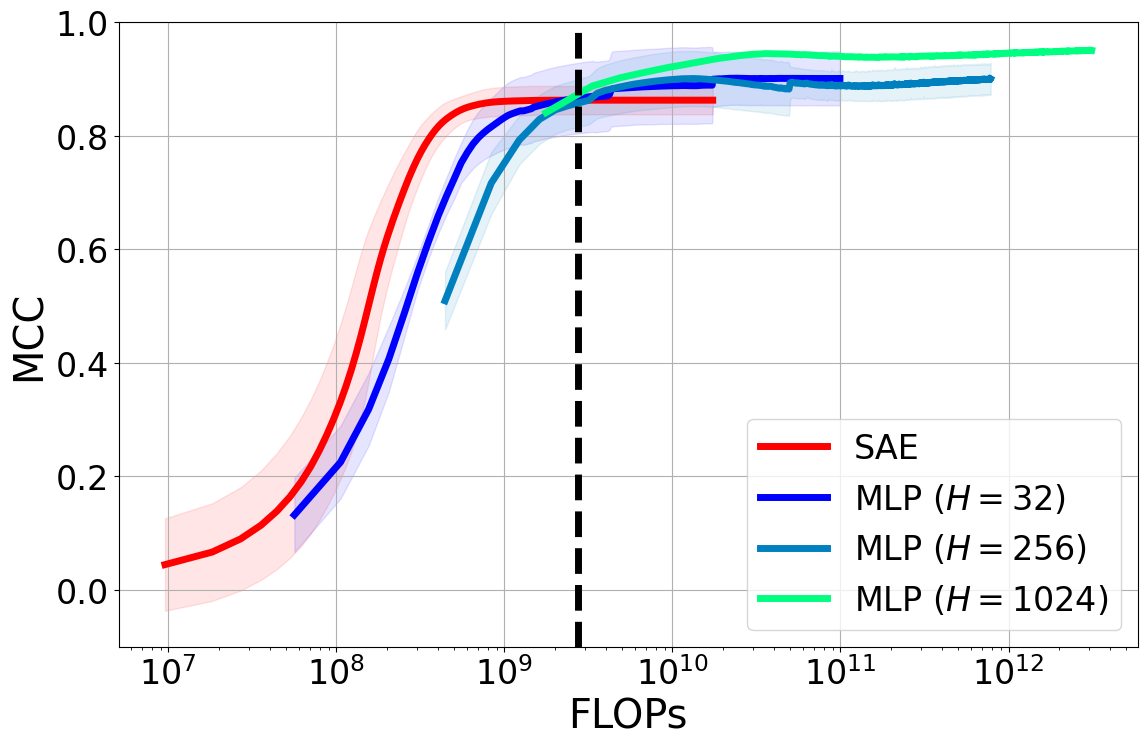

Average crossover point: 2.73e+09 FLOPs


In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_Z_training_steps_and_flops.json', 'r') as f:
    data = json.load(f)

# Function to find crossover point
def find_crossover(sae_flops, sae_mcc, mlp_flops, mlp_mcc):
    for i in range(1, len(mlp_mcc)):
        if mlp_mcc[i-1] <= sae_mcc[-1] and mlp_mcc[i] > sae_mcc[-1]:
            return (mlp_flops[i-1] + mlp_flops[i]) / 2
    return None

# Calculate crossover points
sae_flops = np.array(data['SAE']['flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])

crossover_points = []
for h, mlp_data in data['MLPs'].items():
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    crossover = find_crossover(sae_flops, sae_mcc, mlp_flops, mlp_mcc)
    if crossover is not None:
        crossover_points.append(crossover)

average_crossover = np.mean(crossover_points) if crossover_points else None

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP ($H={h}$)', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)

# Plot average crossover line
if average_crossover:
    plt.axvline(x=average_crossover, color='black', linestyle='--', linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_Z_flops.pdf', dpi=300, bbox_inches='tight')
plt.show()

if average_crossover:
    print(f"Average crossover point: {average_crossover:.2e} FLOPs")
else:
    print("No crossover points found")

## Fixed $D^*$

In [7]:
def calculate_sparse_coding_inference_flops(M, N, num_samples, learn_D=False):
    """
    Calculate the number of FLOPs for inference in SparseCoding.
    
    Args:
    M (int): Number of measurements
    N (int): Number of sparse sources
    num_samples (int): Number of samples to perform inference on
    learn_D (bool): Whether D is being learned or not
    
    Returns:
    int: Total number of FLOPs for inference
    """
    flops = 0
    
    if learn_D:
        # Normalization of D_
        flops += M * N * 2  # Norm calculation
        flops += M * N     # Division
    
    # Exponential of log_S_
    flops += N * num_samples
    
    # Matrix multiplication (S_ @ D_)
    flops += 2 * M * N * num_samples
    
    return flops

def calculate_sparse_coding_training_flops(M, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training SparseCoding.
    
    Args:
    M (int): Number of measurements
    N (int): Number of sparse sources
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether D is being learned or not
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_sparse_coding_inference_flops(M, N, 1, learn_D)
    
    # Loss calculation
    loss_flops = M * batch_size * 2  # MSE
    loss_flops += N * batch_size     # L1
    
    # Backward pass FLOPs (approximation, actual might vary based on autograd)
    backward_flops = forward_flops * 2  # Roughly twice the forward pass
    
    # Parameter updates
    update_flops = N * batch_size
    if learn_D:
        update_flops += M * N
    
    # Total FLOPs for one training iteration
    flops_per_iteration = forward_flops + loss_flops + backward_flops + update_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

# Example usage
M, N = 8, 16
num_samples = 1024
train_flops = calculate_sparse_coding_training_flops(M, N, num_samples, 20000, learn_D=True)
print(f"Total FLOPs for training: {train_flops}")
inference_flops = calculate_sparse_coding_inference_flops(M, N, num_samples, learn_D=True)
print(f"Total FLOPs for inference: {inference_flops}")

def calculate_sae_training_flops(M, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether the decoder weights are being learned
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (including decoder)
    forward_flops = 2 * M * N + N + 2 * N * M  # Encoder + ReLU + Decoder
    if learn_D:
        forward_flops += M * N  # Normalization of D
    
    # Backward pass FLOPs
    relu_grad_flops = N  # ReLU gradient
    linear_grad_flops = (2 * N * M) + N  # Linear layer gradient
    decoder_grad_flops = 2 * N * M  # Decoder gradient
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * N + N)  # Encoder weight update
    if learn_D:
        weight_update_flops += 2 * N * M  # Decoder weight update
    
    backward_flops = relu_grad_flops + linear_grad_flops + decoder_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

def calculate_mlp_training_flops(M, h, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether the decoder weights are being learned
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (including decoder)
    forward_flops = 2 * M * h + h + 2 * h * N + N + 2 * N * M  # First layer + ReLU + Second layer + ReLU + Decoder
    if learn_D:
        forward_flops += M * N  # Normalization of D
    
    # Backward pass FLOPs
    relu2_grad_flops = N
    linear2_grad_flops = (2 * N * h) + N
    relu1_grad_flops = h
    linear1_grad_flops = (2 * M * h) + h
    decoder_grad_flops = 2 * N * M
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * h + h + h * N + N)  # Encoder weight update
    if learn_D:
        weight_update_flops += 2 * N * M  # Decoder weight update
    
    # Total backward pass FLOPs
    backward_flops = relu2_grad_flops + linear2_grad_flops + relu1_grad_flops + linear1_grad_flops + decoder_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_training_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    # Total FLOPs for testing (inference on test set)
    #total_testing_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    
    # Grand total FLOPs
    grand_total_flops = total_training_flops #+ total_testing_flops
    
    return grand_total_flops

def calculate_mlp_inference_flops(M, h, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # First Linear layer FLOPs
    linear1_flops = 2 * M * h
    
    # First ReLU activation FLOPs
    relu1_flops = h
    
    # Second Linear layer FLOPs
    linear2_flops = 2 * h * N
    
    # Second ReLU activation FLOPs
    relu2_flops = N
    
    # Decoder (output) layer FLOPs
    decoder_flops = 2 * N * M
    
    # Total FLOPs for one sample
    flops_per_sample = linear1_flops + relu1_flops + linear2_flops + relu2_flops + decoder_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_sae_inference_flops(M, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # Encoder Linear layer FLOPs
    encoder_flops = 2 * M * N  # includes matrix multiplication and bias addition
    
    # ReLU activation FLOPs
    relu_flops = N  # one comparison per output neuron
    
    # Decoder Linear layer FLOPs
    decoder_flops = 2 * N * M  # matrix multiplication for reconstruction
    
    # Total FLOPs for one sample
    flops_per_sample = encoder_flops + relu_flops + decoder_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

Total FLOPs for training: 1049559040000
Total FLOPs for inference: 278912


In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SparseAutoEncoder(nn.Module):
    def __init__(self, M, N, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        if self.learn_D:
            # Assert that D is not None
            assert D is not None, "D must be provided if learn_D is True"
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        self.decoder = nn.Linear(N, M, bias=False)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class MLP(nn.Module):
    def __init__(self, M, N, h, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        if self.learn_D:
            # Assert that D is not None
            assert D is not None, "D must be provided if learn_D is True"
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU())
        self.decoder = nn.Linear(N, M)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T.clone(), requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D.clone(), requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.05):
    recon_loss = F.mse_loss(X_, X)
    l1_loss = l1_weight * torch.mean(torch.abs(S_))
    return recon_loss + l1_loss

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    # Calculate initial FLOPs
    if isinstance(model, SparseAutoEncoder):
        total_flops = calculate_sae_training_flops(M, N, num_data, 0, learn_D=model.learn_D)
    elif isinstance(model, MLP):
        h = model.encoder[0].out_features
        total_flops = calculate_mlp_training_flops(M, h, N, num_data, 0, learn_D=model.learn_D)
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            # Print every 1000 steps
            if i % 1000 == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}")
            
            # Calculate and log total FLOPs up to this point
            if isinstance(model, SparseAutoEncoder):
                training_flops = calculate_sae_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                inference_flops = calculate_sae_inference_flops(M, N, num_data)
                total_flops = training_flops + inference_flops
            elif isinstance(model, MLP):
                h = model.encoder[0].out_features
                training_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1, learn_D=model.learn_D)
                inference_flops = calculate_mlp_inference_flops(M, h, N, num_data)
                total_flops = training_flops + inference_flops
            log['flops'].append(total_flops)

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}") 
    
    return log

def run_sae_ito(model, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_test)
        loss = reconstruction_loss_with_l1(X_test, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}")
            
            # Calculate and log total FLOPs up to this point
            total_flops = calculate_sparse_coding_training_flops(M, N, X_test.shape[0], i+1, learn_D=model.learn_D)
            log['flops'].append(total_flops)

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}") 
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    if isinstance(model, SparseCoding):
        log = run_sae_ito(model, X_test, S_test, num_step=num_step, log_step=log_step)
    else:
        log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'flops': logs[0]['flops']  # FLOPs are deterministic, so we can just take the first run
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}
logs_sae_ito = []

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i

    SAE = SparseAutoEncoder(M, N, D.to(device), learn_D=False, seed=run_seed)
    print(f"Running experiment {i+1}/{num_runs} with SAE")
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))

    SAE_ITO = SparseCoding(X_test, D.to(device), learn_D=False, seed=run_seed)
    print(f"Running experiment {i+1}/{num_runs} with SAE_ITO")
    logs_sae_ito.append(run_experiment(SAE_ITO, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        print(f"Running experiment {i+1}/{num_runs} with MLP (H={h})")
        MLP_model = MLP(M, N, h, D.to(device), learn_D=False, seed=run_seed).to(device)
        logs_mlps[h].append(run_experiment(MLP_model, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_sae_ito = average_logs(logs_sae_ito)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "SAE_ITO": avg_sae_ito,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_flops_reconstruction.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/fixed_Z_flops_reconstruction.json'.")

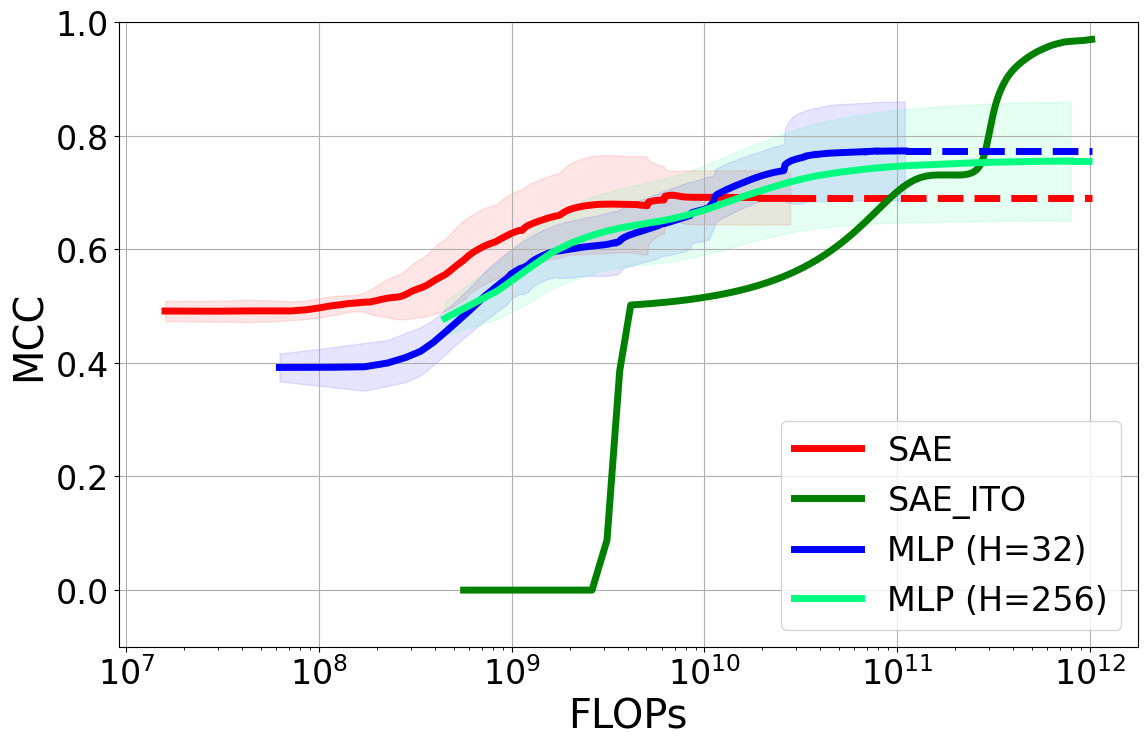

In [34]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_Z_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['flops'][-1],
    data['SAE_ITO']['flops'][-1],
    max(data['MLPs'][h]['flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_mcc[-1], sae_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['flops'])
sae_ito_mcc = np.array(data['SAE_ITO']['mcc_test'])
sae_ito_mcc_std = np.array(data['SAE_ITO']['mcc_test_std'])

plt.plot(sae_ito_flops, sae_ito_mcc, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_mcc - sae_ito_mcc_std, sae_ito_mcc + sae_ito_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_mcc[-1], sae_ito_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_mcc[-1], mlp_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_Z_flops_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

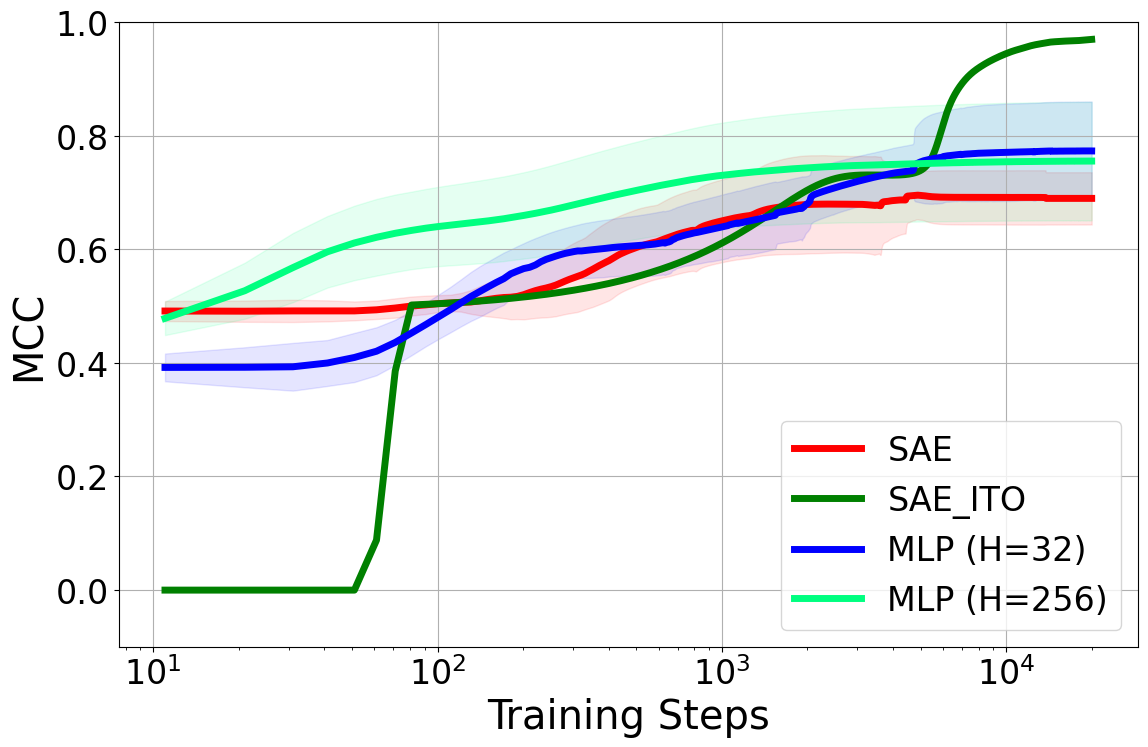

In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_Z_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['mcc_test']) - np.array(avg_sae['mcc_test_std']),
                 np.array(avg_sae['mcc_test']) + np.array(avg_sae['mcc_test_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['mcc_test'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['mcc_test']) - np.array(avg_sae_ito['mcc_test_std']),
                 np.array(avg_sae_ito['mcc_test']) + np.array(avg_sae_ito['mcc_test_std']),
                 alpha=alpha, color='green')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['mcc_test']) - np.array(avg_mlp['mcc_test_std']),
                     np.array(avg_mlp['mcc_test']) + np.array(avg_mlp['mcc_test_std']),
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_Z_training_steps_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Unknown $Z^*$ and $D^*$

In [25]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc, greedy_mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SparseAutoEncoder(nn.Module):
    def __init__(self, M, N, D, learn_D=True, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        self.decoder = nn.Linear(N, M, bias=False)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class MLP(nn.Module):
    def __init__(self, M, N, h, D, learn_D=True, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU())
        self.decoder = nn.Linear(N, M)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T.clone(), requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        if learn_D:
            self.D = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D = nn.Parameter(data=D, requires_grad=False)
        self.log_S = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)

    def forward(self, X):
        if self.learn_D:
            self.D.data /= torch.linalg.norm(self.D.data, dim=0, keepdim=True)
        S = torch.exp(self.log_S)
        X_ = S @ self.D
        return S, X_

    def optimize_codes(self, X, num_iterations=1000, lr=1e-3):
        log_S_ = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)
        opt = torch.optim.Adam([log_S_], lr=lr)

        for j in range(num_iterations):
            S = torch.exp(log_S_)
            X_ = S @ self.D
            loss = reconstruction_loss_with_l1(X, X_, S)
            opt.zero_grad()
            loss.backward()
            opt.step()

        return torch.exp(log_S_.detach())

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.01):
    recon_loss = F.mse_loss(X_, X)
    l1_loss = l1_weight * torch.mean(torch.abs(S_))
    return recon_loss + l1_loss

def calculate_dict_mcc(D_true, D_learned):
    return greedy_mcc(D_true.T.cpu().numpy(), D_learned.T.cpu().numpy())

def calculate_optimize_codes_flops(M, N, num_data, num_iterations):
    # Initialization FLOPs
    init_flops = M * N + N

    # FLOPs per iteration
    flops_per_iteration = 4 * M * N + 2 * M + 11 * N

    # Total FLOPs
    total_flops = init_flops + (flops_per_iteration * num_iterations)

    # Multiply by num_data as this is done for each data point
    return total_flops * num_data

def train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            # Optimize codes for test set
            #with torch.no_grad():
            S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ model.D
            loss_test = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            
            mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            log['loss_test'].append(loss_test.item())
            log['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC
            dict_mcc = calculate_dict_mcc(D_true, model.D.data)
            log['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs
            train_flops = calculate_sparse_coding_training_flops(M, N, X_train.shape[0], i+1, learn_D=model.learn_D)
            #test_flops = calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False)  # We're not learning D during testing
            test_flops = calculate_optimize_codes_flops(M, N, X_test.shape[0], 10_000)
            log['train_flops'].append(train_flops)
            log['test_flops'].append(test_flops)

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}, Dict MCC = {dict_mcc:.4f}")

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
    return log, model.D.data

def train(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC
            if isinstance(model, SparseAutoEncoder) or isinstance(model, MLP):
                D_learned = model.decoder.weight.data.T
            elif isinstance(model, SparseCoding):
                D_learned = model.D_.data
            dict_mcc = calculate_dict_mcc(D_true, D_learned)
            log['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs
            if isinstance(model, SparseAutoEncoder):
                train_flops = calculate_sae_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_sae_inference_flops(M, N, num_data)
            elif isinstance(model, MLP):
                h = model.encoder[0].out_features
                train_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_mlp_inference_flops(M, h, N, num_data)
            elif isinstance(model, SparseCoding):
                train_flops = calculate_sparse_coding_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_sparse_coding_inference_flops(M, N, num_data, learn_D=model.learn_D)
            log['train_flops'].append(train_flops)
            log['test_flops'].append(test_flops)

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}, Dict MCC = {dict_mcc:.4f} (Train: {train_flops/1e9:.2f}B, Test: {test_flops/1e9:.2f}B)")

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
    return log, model.decoder.weight.data.T if hasattr(model, 'decoder') else model.D_.data

def train_sae_with_ito(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log_sae = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    log_ito = {'step': [], 'mcc_test': [], 'loss_test': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log_sae['step'].append(i)
            log_sae['loss_train'].append(loss.item())
            log_sae['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log_sae['loss_test'].append(loss_test)
            log_sae['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC for SAE
            D_learned = model.decoder.weight.data.T
            dict_mcc = calculate_dict_mcc(D_true, D_learned)
            log_sae['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs for SAE
            train_flops = calculate_sae_training_flops(M, N, X_train.shape[0], i+1, learn_D=model.learn_D)
            test_flops = calculate_sae_inference_flops(M, N, X_test.shape[0])
            log_sae['train_flops'].append(train_flops)
            log_sae['test_flops'].append(test_flops)

            # Run SAE_ITO
            ito_model = SparseCoding(X_test, D_learned, learn_D=False).to(device)
            S_test_opt = ito_model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ ito_model.D
            loss_test_ito = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            mcc_test_ito = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            
            log_ito['step'].append(i)
            log_ito['loss_test'].append(loss_test_ito.item())
            log_ito['mcc_test'].append(mcc_test_ito)
            log_ito['dict_mcc'].append(dict_mcc)  # Same as SAE
            #log_ito['test_flops'].append(calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False))
            log_ito['test_flops'].append(calculate_optimize_codes_flops(M, N, X_test.shape[0], 10_000))

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: SAE Loss Test = {loss_test:.4f}, SAE MCC Test = {mcc_test:.4f}, SAE Dict MCC = {dict_mcc:.4f}")
                print(f"         ITO Loss Test = {loss_test_ito:.4f}, ITO MCC Test = {mcc_test_ito:.4f}")

    print(f"Final SAE MCC: {log_sae['mcc_test'][-1]:.4f}, Final SAE Dict MCC: {log_sae['dict_mcc'][-1]:.4f}")
    print(f"Final ITO MCC: {log_ito['mcc_test'][-1]:.4f}")
    return log_sae, log_ito, D_learned

def run_experiment(model, X_train, S_train, X_test, S_test, D_true, num_step=30000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    if isinstance(model, SparseCoding):
        if model.learn_D:
            log, learned_D = train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            return log, None, learned_D
        else:
            # This is the standalone SAE_ITO case (not used in the main loop anymore)
            S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ model.D
            loss_test = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            dict_mcc = calculate_dict_mcc(D_true, model.D.data)
            test_flops = calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False)
            log = {
                'step': [num_step],
                'mcc_test': [mcc_test],
                'loss_test': [loss_test.item()],
                'train_flops': [0],  # No training for SAE_ITO
                'test_flops': [test_flops],
                'dict_mcc': [dict_mcc]
            }
            learned_D = model.D.data
            print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
            return log, None, learned_D
    elif isinstance(model, SparseAutoEncoder):
        return train_sae_with_ito(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
    else:  # MLP
        log, learned_D = train(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
        return log, None, learned_D

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'dict_mcc': np.mean([log['dict_mcc'] for log in logs], axis=0),
        'dict_mcc_std': np.std([log['dict_mcc'] for log in logs], axis=0),
        'train_flops': logs[0]['train_flops'],
        'test_flops': logs[0]['test_flops']
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 100_000
log_step = 2500
seed = 20240926

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)
D_true = D.to(device)

# Run experiments
logs_sae = []
logs_sae_ito = []
logs_mlps = {h: [] for h in hidden_layers}
logs_sparse_coding = []

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i

    # Sparse Coding
    SC = SparseCoding(X_test, D.to(device), learn_D=True, seed=run_seed).to(device)
    print(f"Running experiment {i+1}/{num_runs} with Sparse Coding")
    sc_log, _, _ = run_experiment(SC, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
    logs_sparse_coding.append(sc_log)

    # SAE and SAE_ITO
    SAE = SparseAutoEncoder(M, N, D.to(device), learn_D=True, seed=run_seed).to(device)
    print(f"Running experiment {i+1}/{num_runs} with SAE and SAE_ITO")
    sae_log, sae_ito_log, _ = run_experiment(SAE, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
    logs_sae.append(sae_log)
    logs_sae_ito.append(sae_ito_log)
    
    for h in hidden_layers:
        print(f"Running experiment {i+1}/{num_runs} with MLP (H={h})")
        MLP_model = MLP(M, N, h, D.to(device), learn_D=True, seed=run_seed).to(device)
        mlp_log, _, _ = run_experiment(MLP_model, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
        logs_mlps[h].append(mlp_log)

def average_logs(logs, ito=False, sae_avg_logs=None):
    if ito:
        assert sae_avg_logs is not None, "SAE average logs must be provided if ito=True"
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'dict_mcc': np.mean([log['dict_mcc'] for log in logs], axis=0),
        'dict_mcc_std': np.std([log['dict_mcc'] for log in logs], axis=0),
        'train_flops': logs[0]['train_flops'] if not ito else sae_avg_logs['train_flops'],
        'test_flops': logs[0]['test_flops']
    }
    return avg_log

# Average logs
avg_sae = average_logs(logs_sae)
avg_sae_ito = average_logs(logs_sae_ito, ito=True, sae_avg_logs=avg_sae)
avg_sparse_coding = average_logs(logs_sparse_coding)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "SAE_ITO": avg_sae_ito,
    "SparseCoding": avg_sparse_coding,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/unknown_Z_D_flops_reconstruction.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/unknown_Z_D_flops_reconstruction.json'.")

Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Running experiment 1/5 with Sparse Coding
Step 0: Loss Test = 0.1788, MCC Test = 0.4149, Dict MCC = 0.6800
Step 5000: Loss Test = 0.2508, MCC Test = 0.3588, Dict MCC = 0.4801
Step 10000: Loss Test = 0.0170, MCC Test = 0.5516, Dict MCC = 0.7317
Step 15000: Loss Test = 0.0131, MCC Test = 0.5974, Dict MCC = 0.7646
Step 20000: Loss Test = 0.0113, MCC Test = 0.6550, Dict MCC = 0.8215
Step 25000: Loss Test = 0.0096, MCC Test = 0.6799, Dict MCC = 0.8318
Step 30000: Loss Test = 0.0104, MCC Test = 0.6640, Dict MCC = 0.8080
Step 35000: Loss Test = 0.0102, MCC Test = 0.6701, Dict MCC = 0.8115
Step 40000: Loss Test = 0.0098, MCC Test = 0.6659, Dict MCC = 0.8110
Step 45000: Loss Test = 0.0093, MCC Test = 0.6729, Dict MCC = 0.8193
Step 50000: Loss Test = 0.0097, MCC Test = 0.6719, Dict MCC = 0.8118
Step 55000: Loss Test = 0.0097, MCC Test = 0.6689, Dict MCC = 0.8069
Step 60000: Loss Test = 0.0097, MCC Test = 0.6670, Dict MCC = 0.8011
Step 65000: Loss Test = 0.0094, MCC Test = 0.6715, Dict MCC = 0.79

Running experiments:  20%|██        | 1/5 [07:38<30:33, 458.39s/it]

Final MCC: 0.7028, Final Dict MCC: 0.8976
Running experiment 2/5 with Sparse Coding
Step 0: Loss Test = 0.1055, MCC Test = 0.4090, Dict MCC = 0.6563
Step 5000: Loss Test = 0.2327, MCC Test = 0.3586, Dict MCC = 0.4885
Step 10000: Loss Test = 0.0133, MCC Test = 0.6393, Dict MCC = 0.8029
Step 15000: Loss Test = 0.0099, MCC Test = 0.6611, Dict MCC = 0.8201
Step 20000: Loss Test = 0.0093, MCC Test = 0.6804, Dict MCC = 0.8289
Step 25000: Loss Test = 0.0095, MCC Test = 0.6885, Dict MCC = 0.8458
Step 30000: Loss Test = 0.0090, MCC Test = 0.6834, Dict MCC = 0.8358
Step 35000: Loss Test = 0.0083, MCC Test = 0.6786, Dict MCC = 0.8318
Step 40000: Loss Test = 0.0080, MCC Test = 0.6755, Dict MCC = 0.8305
Step 45000: Loss Test = 0.0079, MCC Test = 0.6773, Dict MCC = 0.8278
Step 50000: Loss Test = 0.0082, MCC Test = 0.6838, Dict MCC = 0.8257
Step 55000: Loss Test = 0.0085, MCC Test = 0.6851, Dict MCC = 0.8253
Step 60000: Loss Test = 0.0084, MCC Test = 0.6822, Dict MCC = 0.8233
Step 65000: Loss Test = 

Running experiments:  40%|████      | 2/5 [14:17<21:10, 423.62s/it]

Final MCC: 0.4284, Final Dict MCC: 0.7783
Running experiment 3/5 with Sparse Coding
Step 0: Loss Test = 0.0679, MCC Test = 0.5016, Dict MCC = 0.7046
Step 5000: Loss Test = 0.2502, MCC Test = 0.3480, Dict MCC = 0.4751
Step 10000: Loss Test = 0.0177, MCC Test = 0.5117, Dict MCC = 0.7845
Step 15000: Loss Test = 0.0132, MCC Test = 0.5741, Dict MCC = 0.7882
Step 20000: Loss Test = 0.0107, MCC Test = 0.6120, Dict MCC = 0.8340
Step 25000: Loss Test = 0.0119, MCC Test = 0.6105, Dict MCC = 0.8104
Step 30000: Loss Test = 0.0116, MCC Test = 0.5971, Dict MCC = 0.8008
Step 35000: Loss Test = 0.0114, MCC Test = 0.6010, Dict MCC = 0.7991
Step 40000: Loss Test = 0.0114, MCC Test = 0.6150, Dict MCC = 0.7987
Step 45000: Loss Test = 0.0112, MCC Test = 0.6144, Dict MCC = 0.7968
Step 50000: Loss Test = 0.0112, MCC Test = 0.6242, Dict MCC = 0.7982
Step 55000: Loss Test = 0.0110, MCC Test = 0.6247, Dict MCC = 0.7976
Step 60000: Loss Test = 0.0108, MCC Test = 0.6279, Dict MCC = 0.7989
Step 65000: Loss Test = 

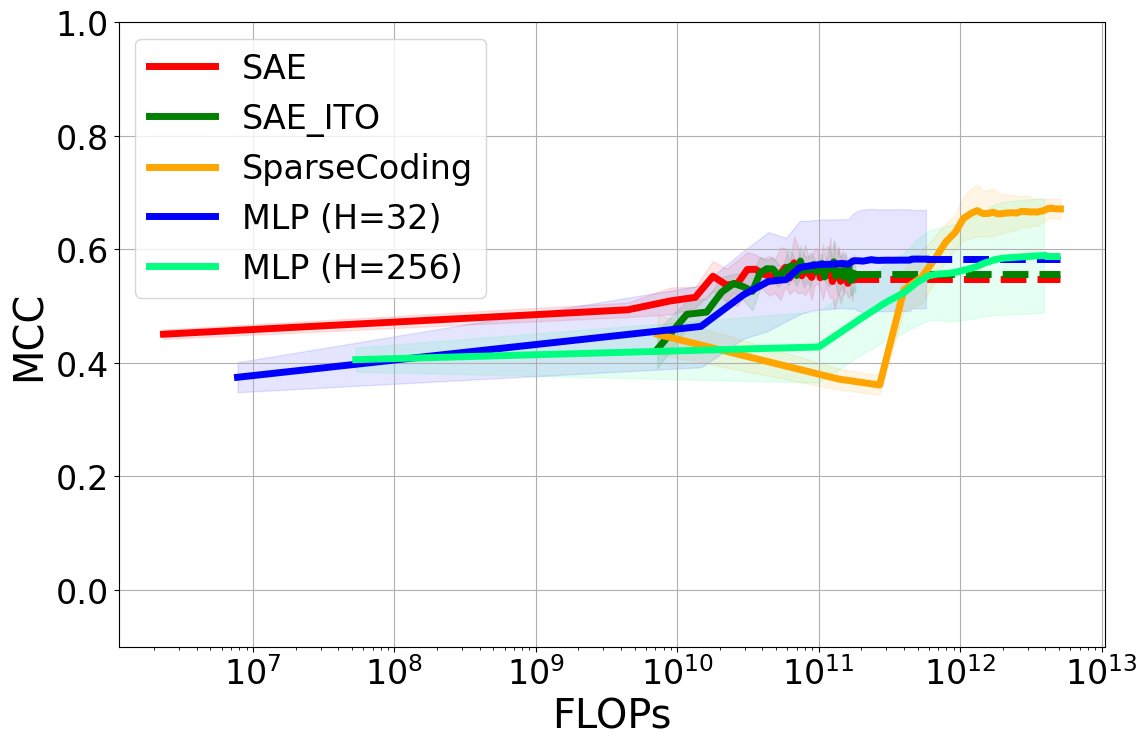

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['train_flops'][-1] + data['SAE']['test_flops'][-1],
    data['SAE_ITO']['train_flops'][-1] + data['SAE_ITO']['test_flops'][-1],
    data['SparseCoding']['train_flops'][-1] + data['SparseCoding']['test_flops'][-1],
    max(data['MLPs'][h]['train_flops'][-1] + data['MLPs'][h]['test_flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['train_flops']) + np.array(data['SAE']['test_flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_mcc[-1], sae_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['train_flops']) + np.array(data['SAE_ITO']['test_flops'])
sae_ito_mcc = np.array(data['SAE_ITO']['mcc_test'])
sae_ito_mcc_std = np.array(data['SAE_ITO']['mcc_test_std'])

plt.plot(sae_ito_flops, sae_ito_mcc, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_mcc - sae_ito_mcc_std, sae_ito_mcc + sae_ito_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_mcc[-1], sae_ito_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot SparseCoding
sc_flops = np.array(data['SparseCoding']['train_flops']) + np.array(data['SparseCoding']['test_flops'])
sc_mcc = np.array(data['SparseCoding']['mcc_test'])
sc_mcc_std = np.array(data['SparseCoding']['mcc_test_std'])

plt.plot(sc_flops, sc_mcc, '-', color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(sc_flops, sc_mcc - sc_mcc_std, sc_mcc + sc_mcc_std, alpha=alpha, color='orange')
# Extend SparseCoding line
plt.plot([sc_flops[-1], max_flops], [sc_mcc[-1], sc_mcc[-1]], '--', color='orange', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['train_flops']) + np.array(mlp_data['test_flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_mcc[-1], mlp_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/unknown_Z_D_flops_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

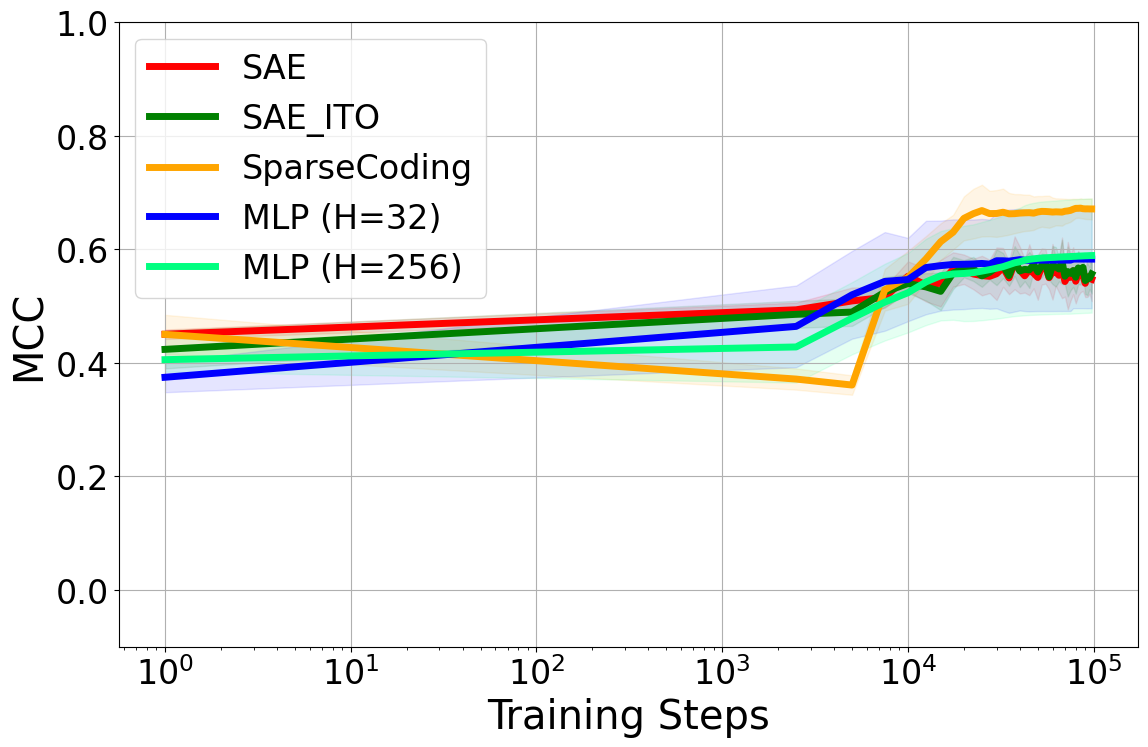

In [21]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_sparse_coding = data['SparseCoding']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['mcc_test']) - np.array(avg_sae['mcc_test_std']),
                 np.array(avg_sae['mcc_test']) + np.array(avg_sae['mcc_test_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['mcc_test'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['mcc_test']) - np.array(avg_sae_ito['mcc_test_std']),
                 np.array(avg_sae_ito['mcc_test']) + np.array(avg_sae_ito['mcc_test_std']),
                 alpha=alpha, color='green')

# Plot SparseCoding
plt.plot(np.array(avg_sparse_coding['step']) + 1, avg_sparse_coding['mcc_test'], '-',
         color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(np.array(avg_sparse_coding['step']) + 1,
                 np.array(avg_sparse_coding['mcc_test']) - np.array(avg_sparse_coding['mcc_test_std']),
                 np.array(avg_sparse_coding['mcc_test']) + np.array(avg_sparse_coding['mcc_test_std']),
                 alpha=alpha, color='orange')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['mcc_test']) - np.array(avg_mlp['mcc_test_std']),
                     np.array(avg_mlp['mcc_test']) + np.array(avg_mlp['mcc_test_std']),
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/unknown_Z_D_training_steps_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

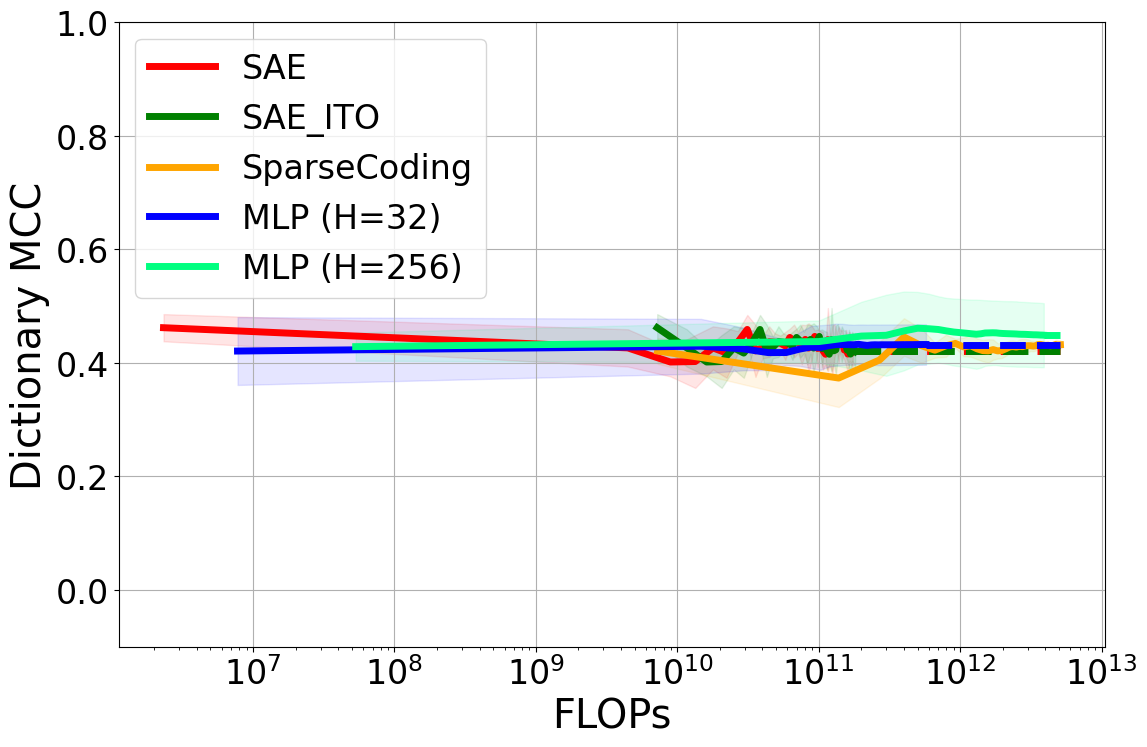

In [22]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['train_flops'][-1] + data['SAE']['test_flops'][-1],
    data['SAE_ITO']['train_flops'][-1] + data['SAE_ITO']['test_flops'][-1],
    data['SparseCoding']['train_flops'][-1] + data['SparseCoding']['test_flops'][-1],
    max(data['MLPs'][h]['train_flops'][-1] + data['MLPs'][h]['test_flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['train_flops']) + np.array(data['SAE']['test_flops'])
sae_dict_mcc = np.array(data['SAE']['dict_mcc'])
sae_dict_mcc_std = np.array(data['SAE']['dict_mcc_std'])

plt.plot(sae_flops, sae_dict_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_dict_mcc - sae_dict_mcc_std, sae_dict_mcc + sae_dict_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_dict_mcc[-1], sae_dict_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['train_flops']) + np.array(data['SAE_ITO']['test_flops'])
sae_ito_dict_mcc = np.array(data['SAE_ITO']['dict_mcc'])
sae_ito_dict_mcc_std = np.array(data['SAE_ITO']['dict_mcc_std'])

plt.plot(sae_ito_flops, sae_ito_dict_mcc, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_dict_mcc - sae_ito_dict_mcc_std, sae_ito_dict_mcc + sae_ito_dict_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_dict_mcc[-1], sae_ito_dict_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot SparseCoding
sc_flops = np.array(data['SparseCoding']['train_flops']) + np.array(data['SparseCoding']['test_flops'])
sc_dict_mcc = np.array(data['SparseCoding']['dict_mcc'])
sc_dict_mcc_std = np.array(data['SparseCoding']['dict_mcc_std'])

plt.plot(sc_flops, sc_dict_mcc, '-', color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(sc_flops, sc_dict_mcc - sc_dict_mcc_std, sc_dict_mcc + sc_dict_mcc_std, alpha=alpha, color='orange')
# Extend SparseCoding line
plt.plot([sc_flops[-1], max_flops], [sc_dict_mcc[-1], sc_dict_mcc[-1]], '--', color='orange', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['train_flops']) + np.array(mlp_data['test_flops'])
    mlp_dict_mcc = np.array(mlp_data['dict_mcc'])
    mlp_dict_mcc_std = np.array(mlp_data['dict_mcc_std'])
    
    plt.plot(mlp_flops, mlp_dict_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_dict_mcc - mlp_dict_mcc_std, mlp_dict_mcc + mlp_dict_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_dict_mcc[-1], mlp_dict_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('Dictionary MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/unknown_Z_D_flops_dict_mcc.pdf', dpi=300, bbox_inches='tight')
plt.show()

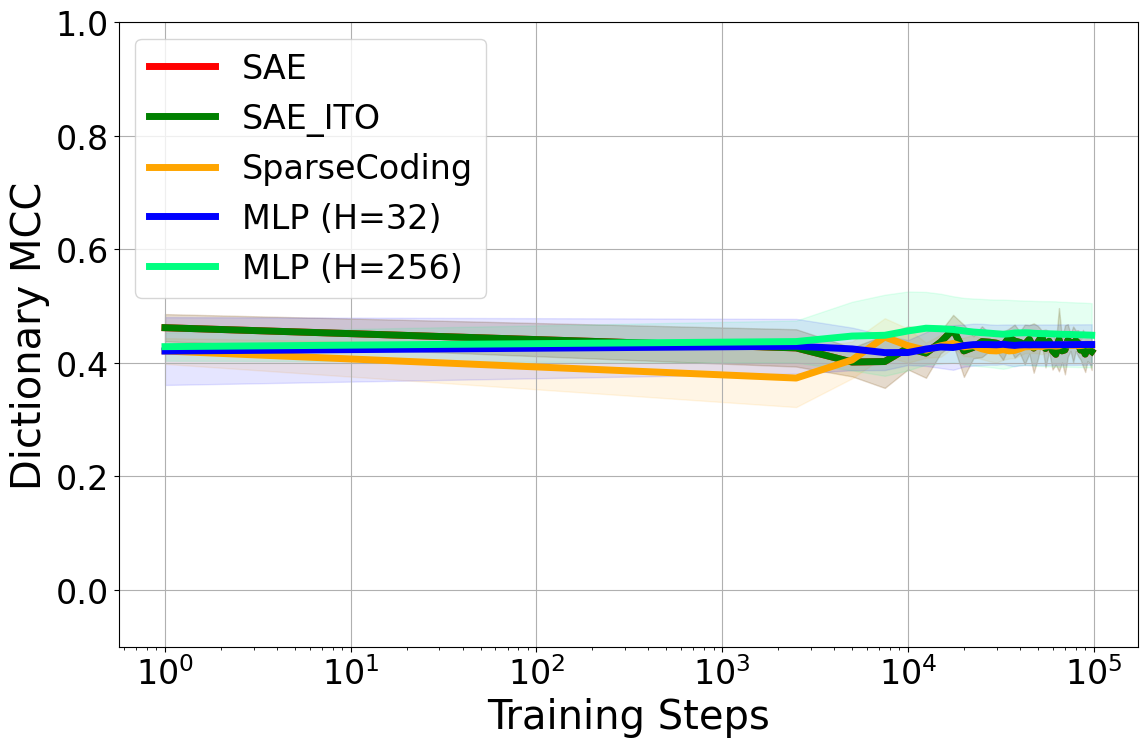

In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_sparse_coding = data['SparseCoding']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['dict_mcc'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['dict_mcc']) - np.array(avg_sae['dict_mcc_std']),
                 np.array(avg_sae['dict_mcc']) + np.array(avg_sae['dict_mcc_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['dict_mcc'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['dict_mcc']) - np.array(avg_sae_ito['dict_mcc_std']),
                 np.array(avg_sae_ito['dict_mcc']) + np.array(avg_sae_ito['dict_mcc_std']),
                 alpha=alpha, color='green')

# Plot SparseCoding
plt.plot(np.array(avg_sparse_coding['step']) + 1, avg_sparse_coding['dict_mcc'], '-',
         color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(np.array(avg_sparse_coding['step']) + 1,
                 np.array(avg_sparse_coding['dict_mcc']) - np.array(avg_sparse_coding['dict_mcc_std']),
                 np.array(avg_sparse_coding['dict_mcc']) + np.array(avg_sparse_coding['dict_mcc_std']),
                 alpha=alpha, color='orange')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['dict_mcc'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['dict_mcc']) - np.array(avg_mlp['dict_mcc_std']),
                     np.array(avg_mlp['dict_mcc']) + np.array(avg_mlp['dict_mcc_std']),
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('Dictionary MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/unknown_Z_D_training_steps_dict_mcc.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Debugging

In [14]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('..')

# Assuming these functions are defined elsewhere
from experiments import generate_data
from metrics import mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
num_data = 1024
seed = 20240925
num_step = 20_000

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D, seed=20240925):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed)
        if learn_D:
            self.D = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D = nn.Parameter(data=D, requires_grad=False)
        self.log_S = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)

    def forward(self, X):
        if self.learn_D:
            self.D.data /= torch.linalg.norm(self.D.data, dim=1, keepdim=True)
        S = torch.exp(self.log_S)
        X_ = S @ self.D
        return S, X_

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.01):
    loss = torch.sum((X - X_) ** 2) + l1_weight * torch.sum(torch.abs(S_))
    return loss

def train_sparse_coding(model, X, S, num_step=30000):
    optim = torch.optim.Adam(model.parameters(), lr=3e-3)
    
    for i in range(num_step):
        S_, X_ = model(X)
        loss = reconstruction_loss_with_l1(X, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i % 1000 == 0:
            train_mcc = mcc(S.cpu().numpy(), S_.detach().cpu().numpy())
            print(f"Step {i}: Loss = {loss.item():.4f} Train MCC = {train_mcc:.4f}")
    
    return model

# Generate data
S, X, D = generate_data(N, M, K, num_data, seed=seed)

# Create and train the model
model = SparseCoding(X, D, learn_D=True, seed=seed).to(device)
trained_model = train_sparse_coding(model, X, S, num_step=num_step)

print("Training completed.")

Step 0: Loss = 3173.1597 Train MCC = 0.0000
Step 1000: Loss = 2773.8567 Train MCC = 0.3186
Step 2000: Loss = 165.3747 Train MCC = 0.5913
Step 3000: Loss = 44.0571 Train MCC = 0.6175
Step 4000: Loss = 37.1701 Train MCC = 0.6385
Step 5000: Loss = 34.4708 Train MCC = 0.6714
Step 6000: Loss = 32.7174 Train MCC = 0.6979
Step 7000: Loss = 31.4013 Train MCC = 0.7242


KeyboardInterrupt: 

In [4]:
# %%
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as corr
import pickle
from tqdm import tqdm
import sys
from munkres import Munkres
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gennorm
from typing import Union

from scipy.fft import dct

from metrics import mcc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

# %%
# parameters
N = 16  # number of sparse sources
K = 3  # number of active components
M = 8  # number of measurements
seed = 20240625
num_data = 1024
lr = 3e-3
num_step = 20000
weight = 1e-2


def criterion(S_, X, X_, weight=weight):
    loss = torch.sum((X - X_) ** 2) + weight * torch.sum(torch.abs(S_))
    return loss

class SparseCoding(nn.Module):
    def __init__(self, S, D, learn_D, seed=seed):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(S.shape), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_

def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model.forward(X)
        loss = criterion(S_, X, X_, weight=weight)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i > 0 and not i % 1000:
            # Print D_
            if not torch.all(S_.var(0) > 0):
                print('dead latents')
            print(f'step {i}, loss {loss.item():.4f}, '
                  f'MCC {mcc(S.detach().cpu().numpy(), S_.detach().cpu().numpy()):.4f}')
    print('final MCC', mcc(S.detach().cpu().numpy(), S_.detach().cpu().numpy()))
    return S_

torch.manual_seed(seed)
#S, X, D = generate_data(N, M, K, num_data, seed=seed)
print(S.shape, X.shape, D.shape)

# 
sc0 = SparseCoding(S, D, learn_D=True, seed=seed).to(device)
S_ = train(sc0)

using cpu
torch.Size([1024, 16]) torch.Size([1024, 8]) torch.Size([16, 8])
step 1000, loss 2759.4897, MCC 0.3050
step 2000, loss 186.3278, MCC 0.5560
step 3000, loss 46.5634, MCC 0.6061
step 4000, loss 37.8071, MCC 0.6511
step 5000, loss 34.3759, MCC 0.6934
step 6000, loss 32.1603, MCC 0.7402
step 7000, loss 30.2994, MCC 0.7939
step 8000, loss 28.4424, MCC 0.8491
step 9000, loss 27.1028, MCC 0.8810
step 10000, loss 26.6628, MCC 0.8899
step 11000, loss 26.9043, MCC 0.8891
step 12000, loss 27.5940, MCC 0.8935
step 13000, loss 27.8359, MCC 0.9000
step 14000, loss 28.3828, MCC 0.8921
step 15000, loss 28.8028, MCC 0.8779
step 16000, loss 29.0104, MCC 0.8608
step 17000, loss 29.4387, MCC 0.8375
step 18000, loss 29.7480, MCC 0.8097
step 19000, loss 29.7556, MCC 0.7936
final MCC 0.789343745392669
